Optimal XGBoost Results:
Mean Absolute Error (MAE): 0.69
Mean Squared Error (MSE): 0.80
R-squared (R^2): 0.23


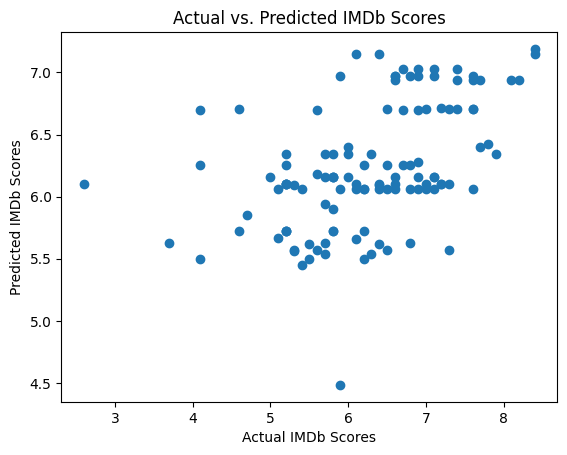

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb


encodings_to_try = ['utf-8', 'ISO-8859-1', 'latin1', 'cp1252']

for encoding in encodings_to_try:
    try:
        data = pd.read_csv('NetflixOriginals.csv', encoding=encoding)
        break
    except UnicodeDecodeError:
        continue

data['IMDB Score'] = data['IMDB Score'].fillna(data['IMDB Score'].mean())

genres = data['Genre'].str.get_dummies(',')
data = pd.concat([data, genres], axis=1)


data['Premiere'] = pd.to_datetime(data['Premiere'])
data['PremiereYear'] = data['Premiere'].dt.year
data = data.drop(['Title', 'Genre', 'Premiere', 'Runtime', 'Language'], axis=1)

X = data.drop(['IMDB Score'], axis=1)
y = data['IMDB Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def create_xgb_model(learning_rate=0.1, n_estimators=200, max_depth=3, random_state=42):
    return xgb.XGBRegressor(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)


xgb_model = create_xgb_model()


param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}


grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3)
grid_search_result = grid_search.fit(X_train, y_train)


best_xgb = grid_search_result.best_estimator_


y_pred_xgb = best_xgb.predict(X_test)


mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("Optimal XGBoost Results:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"R-squared (R^2): {r2_xgb:.2f}")


plt.scatter(y_test, y_pred_xgb)
plt.xlabel("Actual IMDb Scores")
plt.ylabel("Predicted IMDb Scores")
plt.title("Actual vs. Predicted IMDb Scores")
plt.show()
